In [4]:
%%time

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from  datetime import datetime as dt
plt.style.use('fivethirtyeight')
%matplotlib inline

/opt/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:281: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


CPU times: user 841 ms, sys: 199 ms, total: 1.04 s
Wall time: 34.3 s


In [5]:
dfs = {}
dataName = 'temp'
dfs [dataName] = pd.read_csv ('../data/firstPass/GlobalTemperatures.csv', parse_dates = ['dt'])
dfs [dataName] = dfs [dataName].rename (index = str, columns = {'LandAndOceanAverageTemperature': 'TempGlobal', 'LandAverageTemperature': 'TempLand'})
dfs [dataName]['year'] = pd.DatetimeIndex (dfs [dataName]['dt']).year
dfs [dataName] = dfs [dataName].drop (['dt'], axis = 1)
dfs [dataName] = dfs [dataName].groupby ('year')[['TempGlobal', 'TempLand']].mean ()
dfs [dataName] = dfs [dataName] [dfs [dataName].index > 1899]
dfs [dataName] = dfs [dataName] [dfs [dataName].index < 2016]
dfs [dataName].index = dfs [dataName].index.map (unicode)


print
print '####### %s Data Head' % (dataName.capitalize ())
print dfs [dataName].head ()
print
print '####### %s Data Tail' % (dataName.capitalize ())
print dfs [dataName].tail ()
print
print '####### %s Data Shape' % (dataName.capitalize ())
print dfs [dataName].shape


####### Temp Data Head
      TempGlobal  TempLand
year                      
1900   15.143917  8.501583
1901   15.073333  8.541917
1902   14.958333  8.304417
1903   14.836583  8.220167
1904   14.810417  8.090917

####### Temp Data Tail
      TempGlobal  TempLand
year                      
2011   15.769500  9.516000
2012   15.802333  9.507333
2013   15.854417  9.606500
2014   15.913000  9.570667
2015   16.058583  9.831000

####### Temp Data Shape
(116, 2)


In [6]:
dataName = 'disastor'
dfs [dataName] = pd.read_csv ('../data/catastrophes/disastors.csv', parse_dates = ['Year'])
dfs [dataName] = dfs [dataName].rename (index = str, columns = {'Year': 'dt', 'Number of disasters (EMDAT (2017)) (reported disasters)': 'Reports'})
dfs [dataName].index = pd.DatetimeIndex (dfs [dataName]['dt']).year
dfs [dataName] = dfs [dataName].drop (['dt', 'Code'], axis = 1)
# dfs [dataName] = dfs [dataName].groupby ('year')[['TempGlobal', 'TempLand']].mean ()
dfs [dataName] = dfs [dataName] [dfs [dataName].index > 1899]
dfs [dataName] = dfs [dataName] [dfs [dataName].index < 2016]
dfs [dataName].index = dfs [dataName].index.map (unicode)


print
print '####### %s Data Head' % (dataName.capitalize ())
print dfs [dataName].head ()
print
print '####### %s Data Tail' % (dataName.capitalize ())
print dfs [dataName].tail ()
print
print '####### %s Data Shape' % (dataName.capitalize ())
print dfs [dataName].shape


####### Disastor Data Head
                     Entity  Reports
dt                                  
1900  All natural disasters        6
1901  All natural disasters        3
1902  All natural disasters        9
1903  All natural disasters        8
1904  All natural disasters        2

####### Disastor Data Tail
        Entity  Reports
dt                     
2011  Wildfire        8
2012  Wildfire        6
2013  Wildfire       10
2014  Wildfire        4
2015  Wildfire       12

####### Disastor Data Shape
(874, 2)


In [7]:
dfs ['disastor']['Entity'].unique ()

array(['All natural disasters', 'Drought', 'Earthquake', 'Epidemic',
       'Extreme temperature', 'Extreme weather', 'Flood', 'Impact',
       'Landslide', 'Mass movement (dry)', 'Volcanic activity', 'Wildfire'], dtype=object)

In [8]:
dataName = 'disastor'
dfPerEntity = {}
entities = dfs [dataName]['Entity'].unique ()

for entity in entities:
    dfPerEntity [entity] = dfs [dataName][dfs [dataName]['Entity'] == entity]

In [9]:
# We are interested in creating following datasets
# TempLand + All Natural Disasters    | tempAllD
# TempLand + Drought                  | tempDrgt
# TempLand + Earthquake               | tempQuke
# TempLand + Extreme Temperature      | tempExtmp
# TempLand + Extreme Weather          | tempExWth
# TempGlobal + Sea Level + Flood      | tempSeFld
# TempLand + Earthquake + Landslide   | tempEtSld
# Volcanic Activity + Wildfire + TempLand | VoWfTemp
# Volcanic Activity + Wildfire + CO2      | VoWfCo2

datasets = {}
dataName = 'tempAllD'
datasets [dataName] = dfPerEntity ['All natural disasters'].join (dfs ['temp'], how = 'inner')
datasets [dataName] = datasets [dataName].rename (index = str, columns = {'Reports': 'AllDisasters'})
datasets [dataName] = datasets [dataName].drop (['Entity', 'TempGlobal'], axis = 1)

print
print '####### %s Data Head' % (dataName.capitalize ())
print datasets [dataName].head ()
print
print '####### %s Data Tail' % (dataName.capitalize ())
print datasets [dataName].tail ()
print
print '####### %s Data Shape' % (dataName.capitalize ())
print datasets [dataName].shape


####### Tempalld Data Head
      AllDisasters  TempLand
dt                          
1900             6  8.501583
1901             3  8.541917
1902             9  8.304417
1903             8  8.220167
1904             2  8.090917

####### Tempalld Data Tail
      AllDisasters  TempLand
dt                          
2011           361  9.516000
2012           371  9.507333
2013           355  9.606500
2014           342  9.570667
2015           396  9.831000

####### Tempalld Data Shape
(116, 2)


In [39]:
dataName = 'tempDrgt'
datasets [dataName] = dfPerEntity ['Drought'].join (dfs ['temp'], how = 'inner')
datasets [dataName] = datasets [dataName].rename (index = str, columns = {'Reports': 'Droughts'})
datasets [dataName] = datasets [dataName].drop (['Entity', 'TempGlobal'], axis = 1)

print
print '####### %s Data Head' % (dataName.capitalize ())
print datasets [dataName].head ()
print
print '####### %s Data Tail' % (dataName.capitalize ())
print datasets [dataName].tail ()
print
print '####### %s Data Shape' % (dataName.capitalize ())
print datasets [dataName].shape


####### Tempdrgt Data Head
      Droughts  TempLand  deltaTemp  ewmaTemp
1900         2  8.501583        NaN       NaN
1903         1  8.220167  -0.084250 -0.100546
1906         1  8.379083   0.153917  0.007255
1910         9  8.223000   0.044750 -0.006331
1919         1  8.382250   0.251417  0.022541

####### Tempdrgt Data Tail
      Droughts  TempLand  deltaTemp  ewmaTemp
2011        17  9.516000  -0.187083  0.002240
2012        21  9.507333  -0.008667  0.000422
2013         9  9.606500   0.099167  0.016880
2014        18  9.570667  -0.035833  0.008094
2015        28  9.831000   0.260333  0.050134

####### Tempdrgt Data Shape
(70, 4)


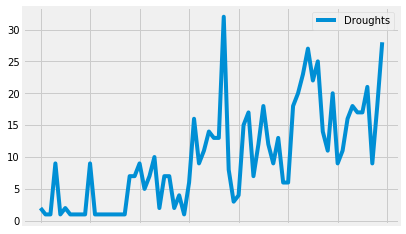

In [42]:
datasets ['tempDrgt'].plot (y = 'Droughts')

dfs ['temp']['TempLand'].plot ()

In [14]:
dfs ['temp']['deltaTemp'] = dfs ['temp']['TempLand'] - dfs ['temp']['TempLand'].shift (1)

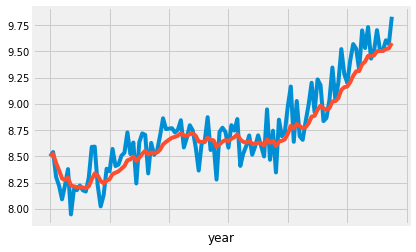

In [35]:
dfs ['temp']['ewmaTemp'] = dfs ['temp']['TempLand'].ewm (com = 0).mean ()
dfs ['temp']['ewmaTemp'].plot ()
dfs ['temp']['ewmaTemp'] = dfs ['temp']['TempLand'].ewm (com = 5).mean ()
dfs ['temp']['ewmaTemp'].plot ()